## Metalearning Notes
*Calvin Tong, George Austin 2018-09-17*

## Introduction

Metalearning is the idea that one can learn to learn by solving many tasks. As humans, this is something we do all the time and one of the halmarks of intelligence. For example, when we see one example of a handwritten symbol, we can immediatly recognize most other examples. We do this without thinking, but this property does not carry over to modern machine learning models. There is still a lot of work to do to get to this ideal of learning how to learn, but in a sense if we solve this problem, then we will essentially solve all supervised machine learning problems. The first attempts at solving this problem reframe it in the supervised learning case, which means that each training case is treated as a training task.

Some success stories: 

* OMNI dataset given a new character recognize it's class: we've acheived 98% accuracy on this dataset (Mishra et al. 2017)
* Neural architecture search: Find the right architecture (Zoph and Le 2017)
* Hindsight Experience Replay (almost meta learning): Solve a hard problem by making it harder. This is from the RL world, so its easiest framed in movement contexts. Let's say the goal is to reach a certain state A. You create a model that tries to reach A, but reaches B instead. When this happens you can use this to learn now to reach state B. 
* Sim2Real: Allow for transfer from simulation to real robots. This often fails because there are different factors not accounted for in the simulation. The idea is to vary the parameters of the simulation and train a policy that can adapt to these situations 

The idea is to learn parameters $\phi$ such that the model will have low loss given $k$ training iterations. More formally, given a task $\tau$ with loss function $L_\tau$ we preform the minimization

$$
\begin{equation*}
\begin{aligned}
\underset{\phi}{\text{minimize}} && \mathbb{E} [L_\tau (U_\tau^k(\phi))]
\end{aligned}
\end{equation*}
$$

where $U_\tau^k$ is an operator defining k updates to $\phi$ using data sampled from $\tau$.


For this presentation, we're going to focus on two recent, similar algorithms, [Model-Agnostic Meta-Learning](https://arxiv.org/pdf/1703.03400.pdf) or MAML and it's extension [Reptile](https://arxiv.org/pdf/1803.02999.pdf). In both of these algorithms there is a metalearner and a learner. The learner is trained by the metalearner on tasks drawn from a task distribution $P(\tau)$, and then fine tuned with a few task specific examples.

## General ML Background Notes
* Interesting view of Backprop: 
Find the best circuit given constraints where each data point represents a constraint $F(x_i; \theta) = y_i$

* Reinforcement learning
    * Find a policy that maximises reward, i.e. we maximize $\mathbb{E}[\underset{t}{\sum} r_t]$
    * At a high level: add some randomess to your actions, if your result was better than expected do more in the future repeat


### Why This Works?

![Convergence](images/convergence.png)

This is a somewhat informal argument from the paper on why this method works. The argument is that the algorithms converge to a vector of parameters that is close in Euclidean distance to each task's manifold of optimal solutions. As such we define the problem as 

$$
\begin{aligned}
\underset{\phi}{\text{minimize}} && \mathbb{E_\tau} [\frac{1}{2} D (\phi, W_{\tau})^2]
\end{aligned}
$$

Where $W_{\tau}$ is the set of optimal paramaters for a task $\tau$ and D is the euclidean distance function. We introduce the $\frac{1}{2}$ to make the math easier later. 

In order to deal with this, we have to review some math. Let's define a non-pathological set $S \subset R^d$ and $\phi \in \mathbb{R}^d$. Given that we are working with an appropriatly well behaved subset of $\mathbb{R}^d$, the gradient of the squared distance function $D(\phi, S)^2$ can be well approximated by $2(\phi - proj_S(\phi))$ (TODO: Flush this fact out more intuitivly, something having to do with distance being the min over all points in the set of absolute distances). Recall that this projection is just the closest value (in the euclidean sense) to the vector in the set. Once we have this approximation, it becomes clear that we can rewrite the gradient of our objective function as

$$
\begin{aligned}
\nabla_\phi \mathbb{E_\tau} [\frac{1}{2} D (\phi, W_{\tau})] &= \mathbb{E_\tau} [\frac{1}{2} \nabla_\phi D (\phi, W_{\tau})] \\
&= \mathbb{E_\tau} [\phi - proj_{W_{\tau}}(\phi)]
\end{aligned}
$$

So we can rewrite our gradient update as
$$
\begin{aligned}
\phi &\leftarrow \phi - \alpha \nabla_\phi \frac{1}{2} D (\phi, W_{\tau})^2 \\
&\leftarrow \phi - \alpha (\phi - proj_{W_{\tau}}(\phi)) \\
&\leftarrow (1-\alpha) \phi - \alpha proj_{W_{\tau}}(\phi)
\end{aligned}
$$

Even though we can't compute $proj_{W_{\tau}}(\phi)$ because it requires us to find the set of minimizers for the given task, we can approximate it with gradient decent. So, for each interation of reptile we see that we sample a task and replace $W_{\tau}$ with the result of running k steps of gradient decent.

### Reptile in Action
Reptile is the successor to MAML and acheives similar preformance, but is easier to implement and faster at runtime. 

In [1]:
import numpy as np
from tensorflow import keras
import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
# domain of the sin function
x_all = np.linspace(-5, 5, 50)

# Number of training iterations
n_iter = 30000

# Number of inner training iterations
n_iter_inner = 1

# Number of training mini batches
n_train = 10

# Alpha for inner and outer SGD
alpha_inner = 0.02
alpha_outer = 0.1

# Ploting parameters
eval_epoch = 8
num_plots = 2

In [3]:
def build_model():
    """
    Build simple feedforward network in keras
    """
    model = keras.Sequential()
    model.add(keras.layers.Dense(64, activation='tanh', input_shape=(1,)))
    model.add(keras.layers.Dense(64, activation='tanh'))
    model.add(keras.layers.Dense(1))
    sgd = keras.optimizers.SGD(lr=alpha_inner)
    model.compile(optimizer=sgd,
                  loss='mse',
                  metrics=['accuracy'])
    return model

def gen_task():
    """
    Create regression problem
    """
    phase = np.random.uniform(0, 2*np.pi)
    ampl = np.random.uniform(0.1, 5)
    f_randomsine = lambda x : np.sin(x + phase) * ampl
    return f_randomsine

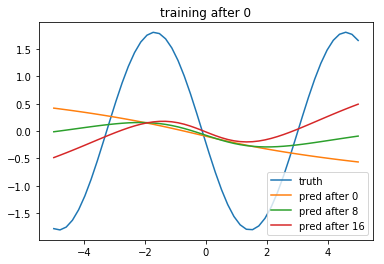

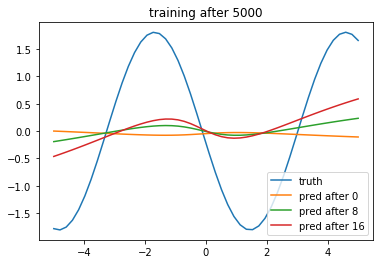

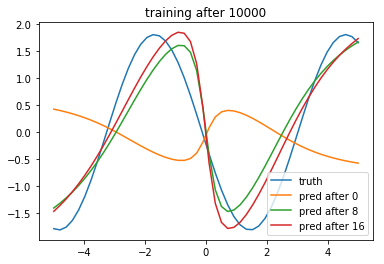

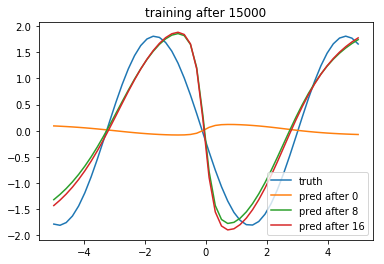

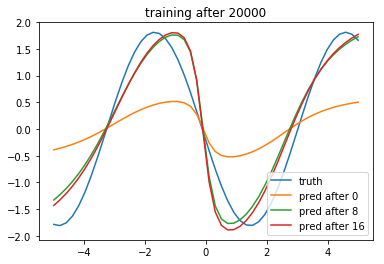

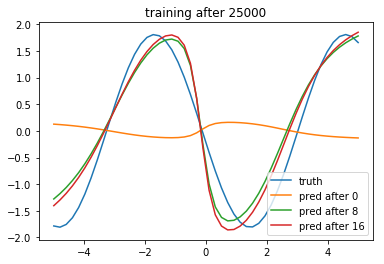

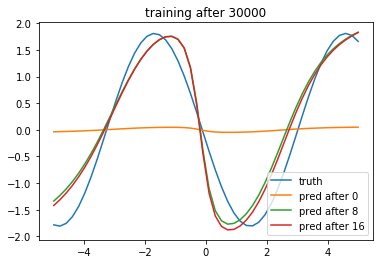

In [4]:
# Build the model
model = build_model()

# Evaluation task
f_eval = gen_task()

for iteration in range(n_iter + 1):
    # Save original weights
    weights_old = np.array(model.get_weights())
    
    # Generate task
    f = gen_task()
    y_all = f(x_all)
    
    # Train on task with SGD
    inds = np.random.permutation(len(x_all))
    for s in range(0, len(x_all), n_train):   
        model.fit(x_all[s:s+n_train], y_all[s:s+n_train], epochs=n_iter_inner, verbose=0)
        
    # Update weights with pseudogradient
    weights_new = np.array(model.get_weights())
    outerstepsize = alpha_outer * (1 - iteration / n_iter)
    update = weights_old + outerstepsize * (weights_new - weights_old)
    model.set_weights(update.tolist())
    
    # Evaluate every 2500 epochs
    if iteration % 5000 == 0:
        # Save weights before
        weights_before = model.get_weights()
        
        # Plot initial predictions
        plt.figure()
        plt.plot(x_all, f_eval(x_all), label="truth")
        plt.plot(x_all, model.predict(x_all), label="pred after 0")
        
        # Train for eval_epoch and plot
        for i in range(num_plots):
            model.fit(x_all, f_eval(x_all), epochs=eval_epoch // num_plots, verbose=0)
            plt.plot(x_all, model.predict(x_all), label="pred after " + str(((i+1) * eval_epoch)))
        plt.legend()
        plt.title("training after " + str(iteration))     
        
        # Restore weights from before
        model.set_weights(weights_before)

### Resources
Good talk by Ilya Sutskeverv https://www.youtube.com/watch?v=AopSlxNYqX8&frags=pl%2Cwn
